# Xgboost for titanic data


In [211]:
# Load in our libraries
import pandas as pd #http://pandas.pydata.org/ #Python Data Analysis Library 
import numpy as np #NumPy is the fundamental package for scientific computing with Python. It contains among other thing
import re #정규식
import sklearn # http://scikit-learn.org/stable/ Simple and efficient tools for data mining and data analysis
import xgboost as xgb # Scalable and Flexible Gradient Boosting https://xgboost.readthedocs.io/en/latest/
import seaborn as sns  # https://seaborn.pydata.org/   seaborn: statistical data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py  #Visualize Data, Togethe #https://plot.ly/
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [212]:
# Load in the train and test datasets
train = pd.read_csv('./data/titanic_train.csv')
test = pd.read_csv('./data/titanic_test.csv')

In [213]:
# Store our passenger ID for easy access
PassengerId = test['PassengerId']

full_data = [train, test]
#print('train row {0}'.format(len(train.index)))
#print('test row {0}'.format(len(test.index)))


# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
#print(train['Name_length'])

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#print(train['Has_Cabin'].head(10))


# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch

#새로운 Feature를 만듭니다.(친척과 자식)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
# IsAlone이 Feature를 새로 만든다.
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    #print(dataset['IsAlone'])
    

# Nan값을 S로 치환한다.
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Nan값을 평균값으로 취소한다.
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
#print(train['CategoricalFare'].values)
# Create a New feature CategoricalAge
# qcut는 같은 갯수로 나눔
# cut은 실수값의 경계선으로 자름

for dataset in full_data:
    age_avg = dataset['Age'].mean()   # 평균
    age_std = dataset['Age'].std()    # 표준편차 구하기 : 분산의 제곱근
    age_null_count = dataset['Age'].isnull().sum()
    print("start random age {0}".format(age_avg - age_std))
    print("end random age {0}".format(age_avg + age_std))
    
    #nan값을 처리 하는 로직.
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
#print(pd.cut(train['Age'], 5).values)

# 정규식을 통해서 Lady.Dr Major등을 추출함
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#print(get_title('Cumings, Mrs. John Bradley (Florence Briggs Th...'))

# Title 컬럼 생성
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#print(dataset['Title'].head(3) )

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

#print(train['Title'].head(3))
#print(train['Embarked'].head(3))
#print(train['Fare'].head(3))

# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

test.head(3)

start random age 15.172620314724776
end random age 44.225614979392866
start random age 16.091381125821364
end random age 44.4537995970702


,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


In [214]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [215]:
import xgboost as xgb
import gc

y_train = train['Survived'].values
x_train = train.drop(['Survived'],axis=1)
x_test = test.values 
print(test.shape)

#print(x_train.head(3))


print(x_train.shape, y_train.shape)

#split test data
#split = 650
#x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

x_train, y_train, x_valid, y_valid = x_train, y_train, x_train, y_train
# print(x_train.shape, x_valid.shape)

# #y_valid = test['Survived'].values
# #x_valid = test.pop('Survived')



# # train_columns = x_train.columns

# # for c in x_train.dtypes[x_train.dtypes == object].index.values:
# #     x_train[c] = (x_train[c] == True)

# # del df_train; gc.collect()

# # split = 80000
# # x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

# #print('Building DMatrix...')

(418, 11)
(891, 11) (891,)


In [216]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

#del x_train, x_valid; gc.collect()

print('Training ...')

params = {}
params['n_estimators']= 2000
params['max_depth'] = 4
params['min_child_weight'] = 2
params['gamma'] = 0.9
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8
params['objective'] = 'binary:logistic'
params['nthread'] = -1


watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

Training ...
[0]	train-error:0.164983	valid-error:0.164983
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[10]	train-error:0.142536	valid-error:0.142536
[20]	train-error:0.141414	valid-error:0.141414
[30]	train-error:0.125701	valid-error:0.125701
[40]	train-error:0.123457	valid-error:0.123457
[50]	train-error:0.114478	valid-error:0.114478
[60]	train-error:0.108866	valid-error:0.108866
[70]	train-error:0.111111	valid-error:0.111111
[80]	train-error:0.099888	valid-error:0.099888
[90]	train-error:0.093154	valid-error:0.093154
[100]	train-error:0.098765	valid-error:0.098765
[110]	train-error:0.094276	valid-error:0.094276
[120]	train-error:0.090909	valid-error:0.090909
[130]	train-error:0.090909	valid-error:0.090909
[140]	train-error:0.088664	valid-error:0.088664
[150]	train-error:0.089787	valid-error:0.089787
[160]	train-error:0.085297	valid-error:0.085297
[170]	train-error:0.087542	valid-e

- MAE : mean absolute error (MAE)

# feature important

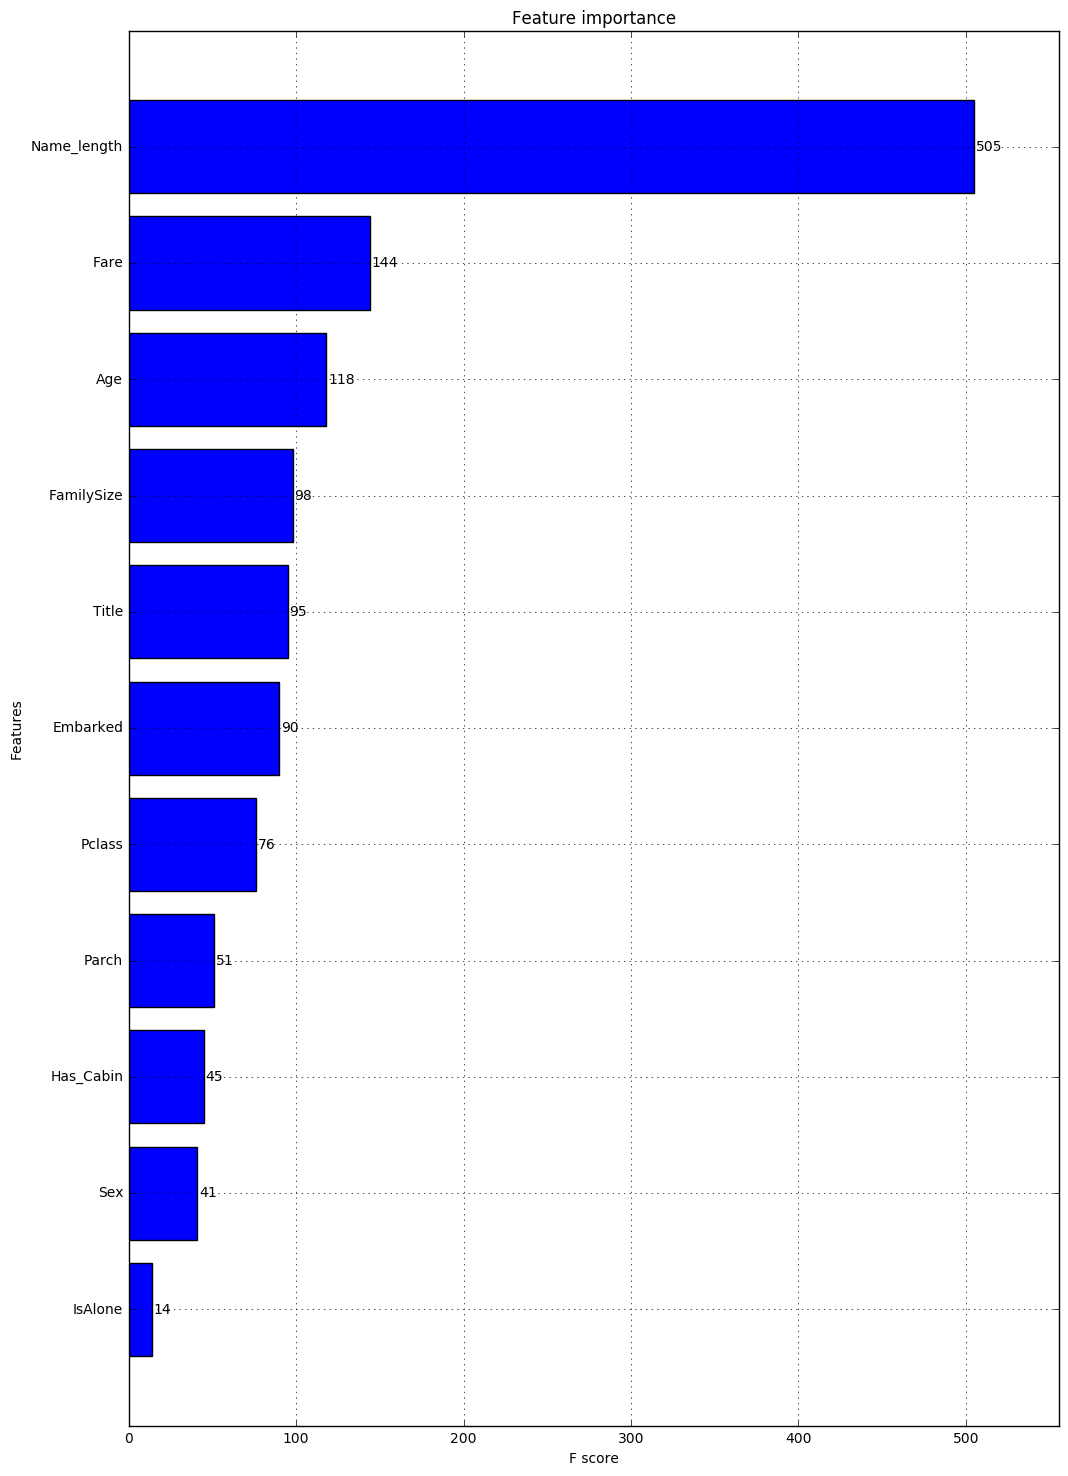

In [217]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [218]:
print(dir(clf))

for ft, score in clf.get_score().items():
     print("feature {0} score {1}".format(ft, score))


['__class__', '__copy__', '__deepcopy__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_validate_features', 'attr', 'attributes', 'best_iteration', 'best_ntree_limit', 'best_score', 'boost', 'copy', 'dump_model', 'eval', 'eval_set', 'feature_names', 'feature_types', 'get_dump', 'get_fscore', 'get_score', 'get_split_value_histogram', 'handle', 'load_model', 'load_rabit_checkpoint', 'predict', 'save_model', 'save_rabit_checkpoint', 'save_raw', 'set_attr', 'set_param', 'update']
feature FamilySize score 98
feature Name_length score 505
feature Parch score 51
feature IsAlone score 14
feature Title score 95
feature Embarked score 90
feature Age score 118
feature Pclass score 76
feature S

# ramdom forest

In [219]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf = RandomForestClassifier(n_jobs= -1,
                            n_estimators= 500,
                            warm_start= True, 
                            max_depth= 6,
                            min_samples_leaf= 2,
                            max_features = 'sqrt',
                            verbose= 0
                           )


In [220]:

rf.fit(x_train, y_train)
print(rf)
print(type(x_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=True)
<class 'pandas.core.frame.DataFrame'>


In [221]:
#print(rf.fit(x_train,y_train).feature_importances_)
rf_features = rf.feature_importances_

In [222]:
cols = x_train.columns.values
print(cols)

#Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
    })

print(feature_dataframe)

['Pclass' 'Sex' 'Age' 'Parch' 'Fare' 'Embarked' 'Name_length' 'Has_Cabin'
 'FamilySize' 'IsAlone' 'Title']
    Random Forest feature importances     features
0                            0.110434       Pclass
1                            0.227984          Sex
2                            0.030516          Age
3                            0.019367        Parch
4                            0.048231         Fare
5                            0.020814     Embarked
6                            0.109357  Name_length
7                            0.059577    Has_Cabin
8                            0.071614   FamilySize
9                            0.010572      IsAlone
10                           0.291534        Title


# kfold



In [225]:
# Some useful parameters which will come in handy later on
ntrain = x_train.shape[0]
ntest = x_train.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)


print(kf)
print(type(x_train))



#sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)

nx_train = x_train.values

rf2 = RandomForestClassifier(n_jobs= -1,
                            n_estimators= 500,
                            warm_start= True, 
                            max_depth= 6,
                            min_samples_leaf= 2,
                            max_features = 'sqrt',
                            verbose= 0
                           )


for i, (train_index, test_index) in enumerate(kf):
    #print(train_index)
    print(train_index.shape)
    #print(x_train.shape)
    x_tr = nx_train[train_index]
    y_tr = y_train[train_index]
    x_te = y_train[test_index]
    rf2.fit(x_tr, y_tr)

    oof_train[test_index] = rf2.predict(x_te)
    #print(oof_train)
    oof_test_skf[i, :] = rf2.predict(x_test)
    #print(oof_train)
print(oof_test_skf)





sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
<class 'pandas.core.frame.DataFrame'>
(712,)


ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 179 